In [1]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [2]:
from keras import applications
from keras import callbacks
from keras.models import Sequential

In [3]:
import efficientnet.keras as efn

model = efn.EfficientNetB7(weights='imagenet')

268317848/268317848 [==============================] - 2s 0us/step


In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [6]:
!unzip Emergency_Vehicles.zip -d .

Archive:  Emergency_Vehicles.zip
   creating: ./Emergency_Vehicles/
  inflating: ./__MACOSX/._Emergency_Vehicles  
   creating: ./Emergency_Vehicles/test/
  inflating: ./__MACOSX/Emergency_Vehicles/._test  
  inflating: ./Emergency_Vehicles/test.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._test.csv  
   creating: ./Emergency_Vehicles/train/
  inflating: ./__MACOSX/Emergency_Vehicles/._train  
  inflating: ./Emergency_Vehicles/train.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._train.csv  
  inflating: ./Emergency_Vehicles/sample_submission.csv  
  inflating: ./__MACOSX/Emergency_Vehicles/._sample_submission.csv  
  inflating: ./Emergency_Vehicles/test/63.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._63.jpg  
  inflating: ./Emergency_Vehicles/test/2128.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._2128.jpg  
  inflating: ./Emergency_Vehicles/test/162.jpg  
  inflating: ./__MACOSX/Emergency_Vehicles/test/._162.jpg  
  inflating: ./Emergency_Vehicles/test/61

In [18]:
train_dir = "Emergency_Vehicles/train"
test_dir = "Emergency_Vehicles/test"
train_df = pd.read_csv('Emergency_Vehicles/train.csv')
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


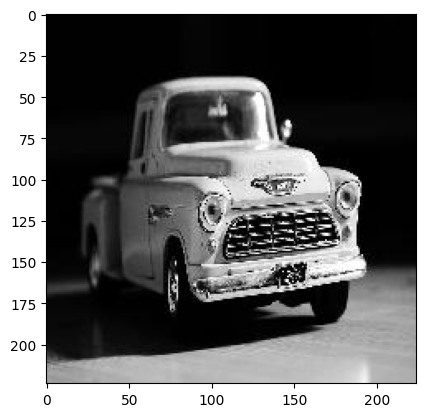

In [8]:
im = cv2.imread("Emergency_Vehicles/train/1002.jpg")
plt.imshow(im)

In [9]:
eff_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

258434480/258434480 [==============================] - 2s 0us/step


In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=150

In [12]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

In [13]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df[:1150],directory=train_dir,x_col='image_names',
                                            y_col='emergency_or_not',class_mode='binary',batch_size=batch_size,
                                            target_size=(32,32))


validation_generator=datagen.flow_from_dataframe(dataframe=train_df[1151:],directory=train_dir,x_col='image_names',
                                                y_col='emergency_or_not',class_mode='binary',batch_size=50,
                                                target_size=(32,32))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


In [14]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = efn.EfficientNetB7(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 2560)             64097680  
 )                                                               
                                                                 
 dense (Dense)               (None, 120)               307320    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 64,419,641
Trainable params: 64,108,921
Non-trainable params: 310,720
_________________________________________________________________


In [15]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
%%time
# Train model
history = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch = 5,
    validation_data = validation_generator,
    validation_steps = 7
)

<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
5/5 [==============================] - 2s 448ms/step - loss: 0.2868 - accuracy: 0.8957 - val_loss: 0.6235 - val_accuracy: 0.6543
Epoch 2/30
5/5 [==============================] - 4s 789ms/step - loss: 0.2598 - accuracy: 0.8987 - val_loss: 0.6195 - val_accuracy: 0.6486
Epoch 3/30
5/5 [==============================] - 3s 560ms/step - loss: 0.2407 - accuracy: 0.9071 - val_loss: 0.6284 - val_accuracy: 0.6714
Epoch 4/30
5/5 [==============================] - 3s 556ms/step - loss: 0.2247 - accuracy: 0.9186 - val_loss: 0.6460 - val_accuracy: 0.6571
Epoch 5/30
5/5 [==============================] - 3s 562ms/step - loss: 0.2074 - accuracy: 0.9314 - val_loss: 0.6340 - val_accuracy: 0.6829
Epoch 6/30
5/5 [==============================] - 3s 502ms/step - loss: 0.2029 - accuracy: 0.9229 - val_loss: 0.6596 - val_accuracy: 0.6486
Epoch 7/30
5/5 [==============================] - 3s 564ms/step - loss: 0.1578 - accuracy: 0.9371 - val_loss: 0.6182 - val_accuracy: 0.7114
Epoch 8/30
5/5 [====

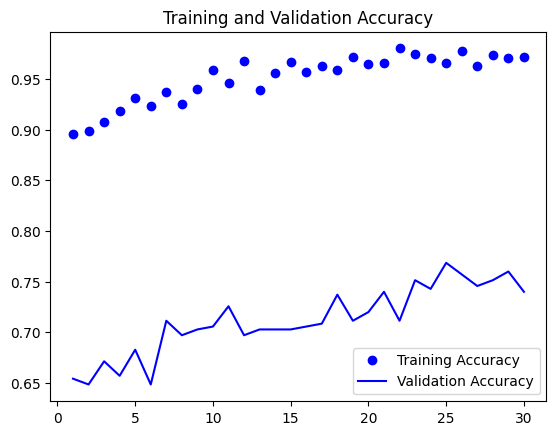

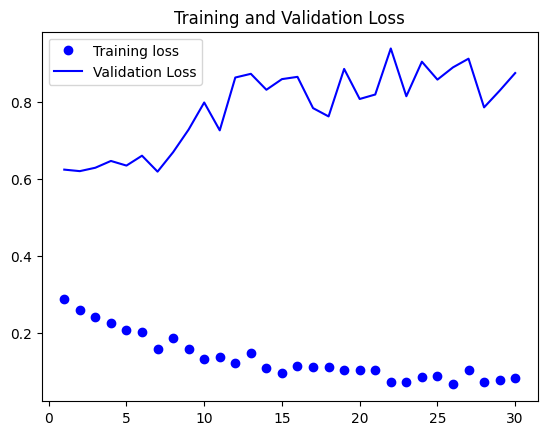

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [31]:
test_df = pd.read_csv('Emergency_Vehicles/test.csv')

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col="image_names",
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 706 validated image filenames.


In [32]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

<ipython-input-32-224ef71c1eac>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(


In [33]:
preds

array([[1.00932244e-04],
       [9.70155895e-01],
       [1.21676631e-03],
       [5.00891265e-03],
       [9.61981341e-03],
       [9.91961777e-01],
       [9.91354764e-01],
       [9.95759591e-02],
       [7.66918471e-04],
       [7.80540884e-01],
       [7.35005140e-01],
       [3.82659351e-03],
       [4.79961094e-03],
       [1.79454184e-03],
       [3.63628729e-03],
       [7.04355717e-01],
       [4.42383345e-04],
       [2.73232814e-03],
       [9.60152030e-01],
       [9.99068320e-01],
       [9.99123514e-01],
       [3.03933680e-01],
       [5.13397992e-01],
       [3.11751175e-03],
       [8.40306699e-01],
       [8.41532089e-03],
       [1.03473365e-01],
       [6.84515238e-01],
       [5.44142909e-03],
       [9.91837204e-01],
       [2.84170508e-02],
       [7.02070594e-02],
       [1.27454940e-02],
       [3.88578326e-02],
       [9.96445000e-01],
       [2.68829335e-03],
       [4.15181667e-01],
       [8.56678188e-01],
       [6.19025854e-03],
       [8.14920604e-01],


In [34]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'image_names': image_ids, 'emergency_or_not':predictions}
submission = pd.DataFrame(data)
print(submission.head())

  image_names  emergency_or_not
0    1960.jpg          0.000101
1     668.jpg          0.970156
2    2082.jpg          0.001217
3     808.jpg          0.005009
4    1907.jpg          0.009620


In [35]:
submission['emergency_or_not'] = submission['emergency_or_not'].apply(lambda x: 1 if x > 0.75 else 0)


In [36]:
submission.to_csv('submission_effnet.csv',index=False)
